<a href="https://colab.research.google.com/github/Mainakdeb/project-jurkat/blob/main/project-jurkat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [114]:
import pandas as pd
import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from albumentations import *
import torchvision.transforms as transforms
from tqdm.notebook import tnrange, tqdm
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [19]:
!wget https://data.broadinstitute.org/bbbc/BBBC048/BBBC048v1.zip

--2021-02-19 06:17:24--  https://data.broadinstitute.org/bbbc/BBBC048/BBBC048v1.zip
Resolving data.broadinstitute.org (data.broadinstitute.org)... 69.173.92.29
Connecting to data.broadinstitute.org (data.broadinstitute.org)|69.173.92.29|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1611429608 (1.5G) [application/zip]
Saving to: ‘BBBC048v1.zip.1’

BBBC048v1.zip.1     100%[===================>]   1.50G  13.1MB/s    in 88s     

2021-02-19 06:18:53 (17.4 MB/s) - ‘BBBC048v1.zip.1’ saved [1611429608/1611429608]



In [20]:
!wget https://data.broadinstitute.org/bbbc/BBBC048/Ground_truth.lst

--2021-02-19 06:18:53--  https://data.broadinstitute.org/bbbc/BBBC048/Ground_truth.lst
Resolving data.broadinstitute.org (data.broadinstitute.org)... 69.173.92.29
Connecting to data.broadinstitute.org (data.broadinstitute.org)|69.173.92.29|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2955854 (2.8M)
Saving to: ‘Ground_truth.lst.1’

Ground_truth.lst.1  100%[===================>]   2.82M  9.38MB/s    in 0.3s    

2021-02-19 06:18:53 (9.38 MB/s) - ‘Ground_truth.lst.1’ saved [2955854/2955854]



In [ ]:
!unzip "/content/BBBC048v1.zip"

In [ ]:
!unzip "/content/CellCycle.zip"

In [23]:
my_file = open("/content/Ground_truth.lst", "r")
content = my_file.read()
print(type(content))
print(content[0:200])

<class 'str'>
19	0	./Anaphase/12432_Ch3.ome.jpg
8	0	./Anaphase/12432_Ch4.ome.jpg
35	0	./Anaphase/12432_Ch6.ome.jpg
36	0	./Anaphase/22004_Ch3.ome.jpg
1	0	./Anaphase/22004_Ch4.ome.jpg
42	0	./Anaphase/22004_Ch6.ome.jp


In [24]:
dataframe1 = pd.read_csv("/content/Ground_truth.lst",
                          header=None) 

In [25]:
df=dataframe1[0].str.split(expand=True)
df=df.sample(frac=1)
df

#imagefolder seems like the easier option
#does torch lightning auto mksf?


,0,1,2
7524,23972,4,./G1/17805_Ch3.ome.jpg
61238,60912,5,./G2/41966_Ch6.ome.jpg
20688,34860,4,./G1/3152_Ch3.ome.jpg
71446,80034,6,./S/10959_Ch4.ome.jpg
39729,42978,4,./G1/6369_Ch3.ome.jpg
...,...,...,...
83376,92204,6,./S/31903_Ch3.ome.jpg
56985,47196,5,./G2/34651_Ch3.ome.jpg
70774,404,2,./Prophase/6702_Ch4.ome.jpg
88574,84683,6,./S/4104_Ch6.ome.jpg


In [26]:
#generate csv

import os, csv

cell_df = pd.DataFrame(list())
cell_df.to_csv('cell_cycle.csv')

f=open("cell_cycle.csv",'r+')
w=csv.writer(f)

folders = ["Anaphase", "G1", "G2","Metaphase", "Prophase", "S", "Telophase"]
folders2 = ["G1","G2","S"]

for f in folders2:
  for path, dirs, files in os.walk("/content/CellCycle/"+f+"/"):
      for filename in files:
          w.writerow([path+filename, f])


In [27]:
c = pd.read_csv('./cell_cycle.csv', header=None)
c.columns = ["path","class_name"]
print(c.class_name.unique())
c

['G1' 'G2' 'S']


,path,class_name
0,/content/CellCycle/G1/1116_Ch4.ome.jpg,G1
1,/content/CellCycle/G1/37559_Ch4.ome.jpg,G1
2,/content/CellCycle/G1/23468_Ch6.ome.jpg,G1
3,/content/CellCycle/G1/41914_Ch4.ome.jpg,G1
4,/content/CellCycle/G1/25002_Ch6.ome.jpg,G1
...,...,...
126195,/content/CellCycle/S/41224_Ch3.ome.jpg,S
126196,/content/CellCycle/S/33343_Ch4.ome.jpg,S
126197,/content/CellCycle/S/30851_merged.jpg,S
126198,/content/CellCycle/S/48879_Ch4.ome.jpg,S


In [28]:
#delete non merged rows
c_merged=c[c.path.str[-10:] == "merged.jpg"]
c_merged.to_csv("cell_merged.csv")
c_merged

,path,class_name
6,/content/CellCycle/G1/28877_merged.jpg,G1
9,/content/CellCycle/G1/47128_merged.jpg,G1
15,/content/CellCycle/G1/20256_merged.jpg,G1
19,/content/CellCycle/G1/25811_merged.jpg,G1
26,/content/CellCycle/G1/30444_merged.jpg,G1
...,...,...
126173,/content/CellCycle/S/19411_merged.jpg,S
126177,/content/CellCycle/S/37857_merged.jpg,S
126178,/content/CellCycle/S/48625_merged.jpg,S
126181,/content/CellCycle/S/13067_merged.jpg,S


In [63]:
def image_to_nparray(path):
    i = cv2.imread(path)
    i = cv2.cvtColor(i, cv2.COLOR_BGR2RGB)
    return(np.array(i))

In [100]:
class C_Dataset(Dataset):
    """custom"""

    def __init__(self, csv, root_dir='',augmentation=None, transform=None):
        
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        
        self.transform = transform
        self.root_dir = root_dir
        self.d = csv
        self.augmentation = augmentation
        self.class_dict = {'G1':0,
                           'S': 1,
                           'G2':2}
        
    def __getitem__(self, idx): 

        smol_img_path = str(self.d.iloc[idx][1]) #image path column
        #print(smol_img_path)
        class_name = str(self.d.iloc[idx][2])  #class name column
        #print("class............",class_name)
        #print(class_name)
        full_img_path = self.root_dir + smol_img_path #+ '.png'

        #print(full_img_path)

        img_arr = image_to_nparray(full_img_path)

        if self.augmentation is not None:
            img  = self.augmentation(image = img_arr)
            img2 = img["image"]
            #print(img2)

        if self.transform is not None:
            img_ret = self.transform(img2)
            #print(img_ret)
        
        #return self.class_dict[str(class_name)], img_ret
        return {"x": img_ret,
                "y": torch.tensor(self.class_dict[str(class_name)])
        }


    def __len__(self):
      
        return (len(self.d))


In [110]:
data = C_Dataset(pd.read_csv('/content/cell_merged.csv'), 
                 '',
                 augmentation = Compose([ 
                                        RandomBrightnessContrast( p=0.9),
                                        Rotate(limit=30, interpolation=1, border_mode=4, always_apply=True, p=0.9)
                                        ]),
                transform = transforms.Compose([    
                                                transforms.ToPILImage(),
                                                transforms.Resize((224,224)),
                                                transforms.CenterCrop((128,128)),
                                                transforms.ToTensor()
                                                ])
                )

size:  torch.Size([3, 128, 128])


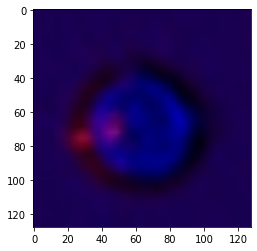

In [111]:
train_loader = torch.utils.data.DataLoader(
    data
    ,batch_size=10
    ,shuffle=True
    # ,pin_memory=True
    # ,num_workers=4
)

for data in tqdm(train_loader):
    print("size: ",data['x'][0].size())
    plt.imshow(data['x'][0].permute(1,2,0))
    plt.show()
    break